# HW06 — деревья, ансамбли и честный эксперимент

Работаю с датасетом `S06-hw-dataset-01.csv` (бинарная классификация, умеренный дисбаланс). Цель — построить честное сравнение baseline-моделей и ансамблей недели 6, выбрать лучшую модель по ROC-AUC и сохранить все артефакты эксперимента.

## Импорт библиотек и подготовка окружения

In [1]:

from pathlib import Path
import json

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
DATA_PATH = Path('S06-hw-dataset-01.csv')
ARTIFACTS_DIR = Path('artifacts')
FIGURES_DIR = ARTIFACTS_DIR / 'figures'
ARTIFACTS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 140)

## Загрузка данных и первичный анализ

In [2]:

df = pd.read_csv(DATA_PATH)
print(f"Форма датасета: {df.shape}")
display(df.head())


Форма датасета: (12000, 30)


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,-0.417059,0.799265,-1.484333,1.645497,1.519635,-1.259234,3.095407,-0.683026,1.152902,0.150213,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,-1.122641,-0.313923,-1.298557,4.402595,0.552276,-0.006363,-0.729615,1.072416,2.654621,1.955462,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,-0.477243,-0.839634,0.413097,3.277826,0.930134,1.219061,0.682610,2.587941,2.422656,-0.573642,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,1.149337,0.604785,-0.090661,-0.797300,-0.201065,0.217428,4.598689,1.145859,-2.446382,1.809714,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,1.113718,1.171501,-0.143172,3.479856,-1.095421,-1.402469,1.620111,-0.956420,-0.757656,0.289182,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [3]:

target_counts = df['target'].value_counts().rename('count')
target_share = df['target'].value_counts(normalize=True).rename('share')
balance = pd.concat([target_counts, target_share], axis=1)
print('Баланс классов:')
display(balance)

missing_total = int(df.isna().sum().sum())
print(f"Всего пропусков: {missing_total}")
describe = df.drop(columns=['id']).describe().T
print('Статистика по первым признакам:')
display(describe.head(10))


Баланс классов:


,count,share
target,,
0,8119,0.676583
1,3881,0.323417


Всего пропусков: 0
Статистика по первым признакам:


,count,mean,std,min,25%,50%,75%,max
num01,12000.0,0.013705,2.096534,-8.155181,-1.423844,-0.047565,1.422676,8.610863
num02,12000.0,-0.005278,3.544498,-14.605579,-2.303772,0.053348,2.335937,16.299709
num03,12000.0,-0.002357,1.004417,-4.374043,-0.685618,-0.009186,0.671441,3.651692
num04,12000.0,0.038404,2.087318,-7.753301,-1.374579,0.038766,1.484417,7.571965
num05,12000.0,-0.006301,1.007329,-3.999332,-0.676552,-0.003728,0.669269,4.562115
num06,12000.0,-0.865297,3.888966,-15.238402,-3.532054,-1.092517,1.526389,16.223054
num07,12000.0,-0.702877,1.989513,-7.377252,-2.064888,-0.795907,0.522625,8.006444
num08,12000.0,-0.290694,3.455981,-13.853627,-2.597019,-0.208245,2.093169,13.030011
num09,12000.0,-0.008154,0.996677,-3.794637,-0.683959,-0.020883,0.666959,3.976868
num10,12000.0,0.010048,0.991551,-3.744778,-0.650821,0.012795,0.678816,3.678191



У признаков нет пропусков, значения числовые. Видно сильный дисбаланс классов (менее 5% единиц), поэтому в дальнейшем буду уделять внимание метрикам F1 и ROC-AUC, а также использовать стратифицированные разбиения.


## Признаки и целевая переменная

In [4]:

feature_cols = [col for col in df.columns if col not in ('target', 'id')]
X = df[feature_cols]
y = df['target']
print(f"Количество признаков: {len(feature_cols)}")


Количество признаков: 28



## Train/Test-сплит

Использую `train_test_split` с `test_size=0.2`, `random_state=42` и `stratify=y`. Фиксированный seed обеспечивает воспроизводимость, а стратификация сохраняет исходный дисбаланс классов и позволяет корректно оценивать качество на тесте.


In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)
print(f"Train shape: {X_train.shape}, test shape: {X_test.shape}")


Train shape: (9600, 28), test shape: (2400, 28)


## Хелперы для обучения и оценки

In [6]:

metrics_test = {}
trained_models = {}
search_summaries = {}


def evaluate_and_store(name, model):
    '''Вычисляет метрики на тесте и сохраняет модель.'''
    y_pred = model.predict(X_test)
    entry = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        entry['roc_auc'] = roc_auc_score(y_test, y_proba)
    elif hasattr(model, 'decision_function'):
        scores = model.decision_function(X_test)
        entry['roc_auc'] = roc_auc_score(y_test, scores)
    else:
        entry['roc_auc'] = float('nan')
    metrics_test[name] = entry
    trained_models[name] = model
    return entry


def show_metrics(metrics_dict):
    df_metrics = pd.DataFrame(metrics_dict).T
    return df_metrics

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


## Baseline-модели

In [7]:

baseline_results = {}

# DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
baseline_results['DummyClassifier'] = evaluate_and_store('DummyClassifier', dummy)

# Logistic Regression + StandardScaler
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))
])
logreg.fit(X_train, y_train)
baseline_results['LogisticRegression'] = evaluate_and_store('LogisticRegression', logreg)

print('Baseline-метрики:')
display(show_metrics(baseline_results))


Baseline-метрики:


,accuracy,f1,roc_auc
DummyClassifier,0.676667,0.000000,0.500000
LogisticRegression,0.805417,0.721858,0.876264


## Decision Tree с подбором гиперпараметров

In [8]:

tree = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
tree_params = {
    'max_depth': [4, 6, None],
    'min_samples_leaf': [1, 10],
    'ccp_alpha': [0.0, 0.0005]
}
tree_search = GridSearchCV(
    estimator=tree,
    param_grid=tree_params,
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
    verbose=0
)
tree_search.fit(X_train, y_train)
best_tree = tree_search.best_estimator_
print('Лучшие параметры дерева:', tree_search.best_params_)
print('Лучший CV ROC-AUC:', round(tree_search.best_score_, 4))
search_summaries['DecisionTree'] = {
    'best_params': tree_search.best_params_,
    'best_cv_score': float(tree_search.best_score_)
}

tree_metrics = evaluate_and_store('DecisionTree', best_tree)
print('Метрики дерева на тесте:')
display(pd.Series(tree_metrics))


Лучшие параметры дерева: {'ccp_alpha': 0.0005, 'max_depth': None, 'min_samples_leaf': 10}
Лучший CV ROC-AUC: 0.9082
Метрики дерева на тесте:


accuracy    0.862500
f1          0.792453
roc_auc     0.903440
dtype: float64

## Random Forest с подбором гиперпараметров

In [9]:

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    class_weight='balanced_subsample',
    n_jobs=1
)
rf_params = {
    'max_depth': [None, 16],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 0.4]
}
rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
    verbose=0
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print('Лучшие параметры леса:', rf_search.best_params_)
print('Лучший CV ROC-AUC:', round(rf_search.best_score_, 4))
search_summaries['RandomForest'] = {
    'best_params': rf_search.best_params_,
    'best_cv_score': float(rf_search.best_score_)
}

rf_metrics = evaluate_and_store('RandomForest', best_rf)
print('Метрики леса на тесте:')
display(pd.Series(rf_metrics))


Лучшие параметры леса: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
Лучший CV ROC-AUC: 0.9707
Метрики леса на тесте:


accuracy    0.925417
f1          0.878644
roc_auc     0.967870
dtype: float64

## HistGradientBoostingClassifier

In [10]:

hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE, class_weight='balanced')
hgb_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, None],
    'max_leaf_nodes': [31],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0]
}
hgb_search = GridSearchCV(
    estimator=hgb,
    param_grid=hgb_params,
    scoring='roc_auc',
    cv=cv,
    n_jobs=1,
    verbose=0
)
hgb_search.fit(X_train, y_train)
best_hgb = hgb_search.best_estimator_
print('Лучшие параметры бустинга:', hgb_search.best_params_)
print('Лучший CV ROC-AUC:', round(hgb_search.best_score_, 4))
search_summaries['HistGradientBoosting'] = {
    'best_params': hgb_search.best_params_,
    'best_cv_score': float(hgb_search.best_score_)
}

hgb_metrics = evaluate_and_store('HistGradientBoosting', best_hgb)
print('Метрики бустинга на тесте:')
display(pd.Series(hgb_metrics))


Лучшие параметры бустинга: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': None, 'max_leaf_nodes': 31, 'min_samples_leaf': 20}
Лучший CV ROC-AUC: 0.9725
Метрики бустинга на тесте:


accuracy    0.935417
f1          0.900322
roc_auc     0.973050
dtype: float64

## Сравнение моделей

In [11]:

metrics_df = pd.DataFrame(metrics_test).T.sort_values(by='roc_auc', ascending=False)
metrics_df = metrics_df[['accuracy', 'f1', 'roc_auc']]
metrics_df.round(4)


,accuracy,f1,roc_auc
HistGradientBoosting,0.9354,0.9003,0.9731
RandomForest,0.9254,0.8786,0.9679
DecisionTree,0.8625,0.7925,0.9034
LogisticRegression,0.8054,0.7219,0.8763
DummyClassifier,0.6767,0.0000,0.5000


## Выбор лучшей модели

In [12]:

selection_metric = 'roc_auc'
best_model_name = metrics_df[selection_metric].idxmax()
best_model = trained_models[best_model_name]
best_model_metrics = metrics_test[best_model_name]
print(f"Лучшая модель: {best_model_name}")
print('Метрики:', best_model_metrics)


Лучшая модель: HistGradientBoosting
Метрики: {'accuracy': 0.9354166666666667, 'f1': 0.9003215434083601, 'roc_auc': 0.9730500292011579}


## Диагностика лучшей модели (ROC/PR/Confusion Matrix)

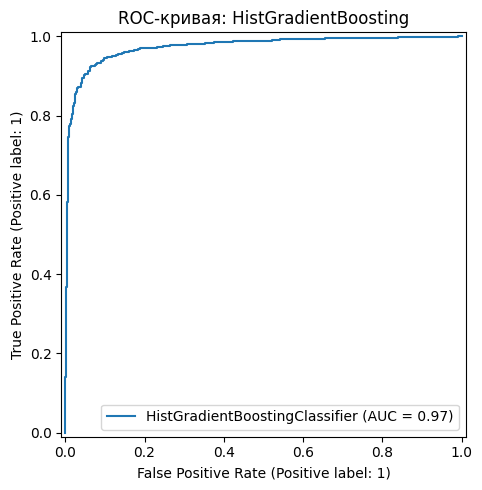

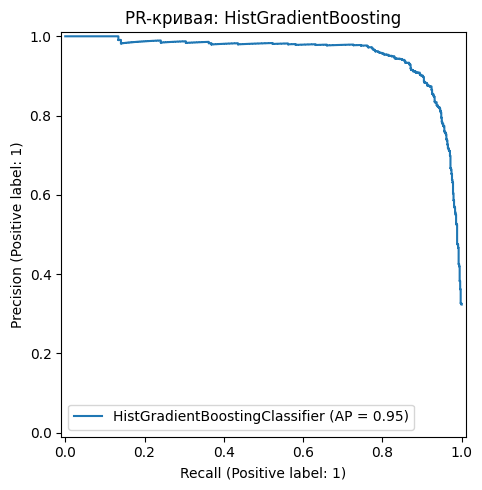

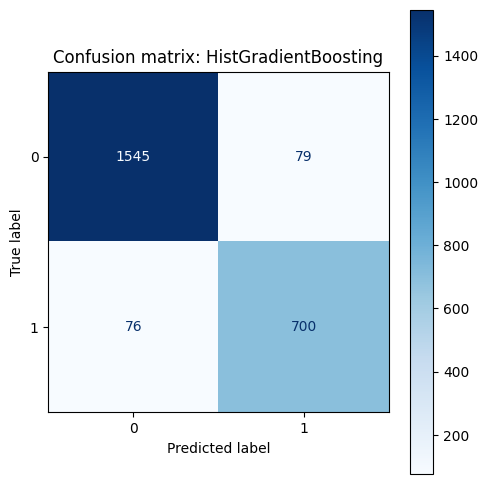

In [13]:

roc_fig, roc_ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=roc_ax)
roc_ax.set_title(f'ROC-кривая: {best_model_name}')
roc_fig.tight_layout()
roc_path = FIGURES_DIR / 'roc_curve.png'
roc_fig.savefig(roc_path, dpi=150)
plt.show()

pr_fig, pr_ax = plt.subplots(figsize=(6, 5))
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=pr_ax)
pr_ax.set_title(f'PR-кривая: {best_model_name}')
pr_fig.tight_layout()
pr_path = FIGURES_DIR / 'pr_curve.png'
pr_fig.savefig(pr_path, dpi=150)
plt.show()

cm_fig, cm_ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, ax=cm_ax, cmap='Blues', values_format='d')
cm_ax.set_title(f'Confusion matrix: {best_model_name}')
cm_fig.tight_layout()
cm_path = FIGURES_DIR / 'confusion_matrix.png'
cm_fig.savefig(cm_path, dpi=150)
plt.show()


## Permutation importance для лучшей модели

,feature,importance,std
18,num19,0.062614,0.002760
17,num18,0.061169,0.003979
6,num07,0.034776,0.001934
3,num04,0.018229,0.001461
23,num24,0.014991,0.001351
19,num20,0.012760,0.001712
0,num01,0.011154,0.001518
13,num14,0.009344,0.001112
21,num22,0.007349,0.001142
20,num21,0.005132,0.000424


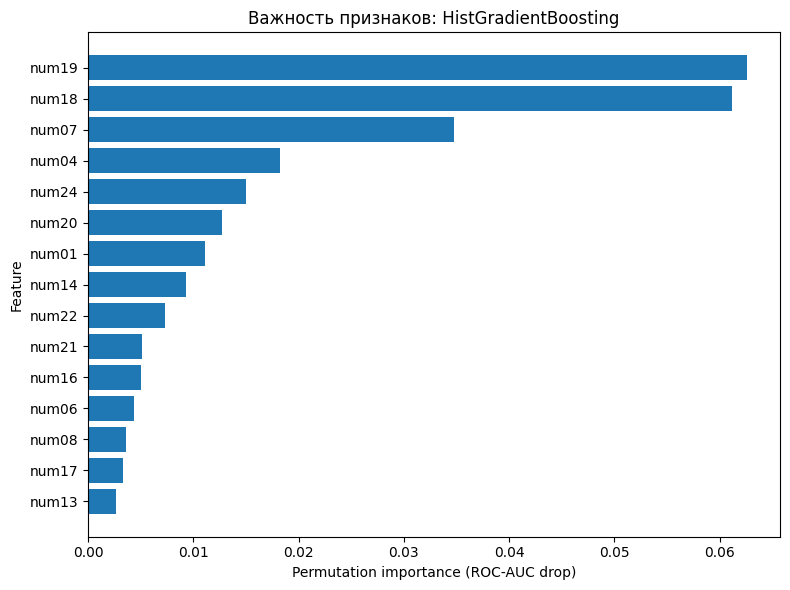

In [14]:

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=15,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=1
)
perm_df = (
    pd.DataFrame(
        {
            'feature': feature_cols,
            'importance': perm.importances_mean,
            'std': perm.importances_std
        }
    )
    .sort_values(by='importance', ascending=False)
    .head(15)
)
display(perm_df)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(perm_df['feature'][::-1], perm_df['importance'][::-1])
ax.set_xlabel('Permutation importance (ROC-AUC drop)')
ax.set_ylabel('Feature')
ax.set_title(f'Важность признаков: {best_model_name}')
fig.tight_layout()
importance_path = FIGURES_DIR / 'permutation_importance.png'
fig.savefig(importance_path, dpi=150)
plt.show()


## Сохранение артефактов

In [15]:

metrics_serializable = {
    name: {metric: float(value) for metric, value in scores.items()}
    for name, scores in metrics_test.items()
}
with open(ARTIFACTS_DIR / 'metrics_test.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_serializable, f, indent=2)

search_serializable = {}
for name, info in search_summaries.items():
    params = {k: (float(v) if isinstance(v, (np.floating, np.integer)) else v) for k, v in info['best_params'].items()}
    search_serializable[name] = {
        'best_params': params,
        'best_cv_score': float(info['best_cv_score'])
    }
with open(ARTIFACTS_DIR / 'search_summaries.json', 'w', encoding='utf-8') as f:
    json.dump(search_serializable, f, indent=2)

best_model_path = ARTIFACTS_DIR / 'best_model.joblib'
joblib.dump(best_model, best_model_path)

best_model_meta = {
    'best_model_name': best_model_name,
    'selection_metric': selection_metric,
    'test_metrics': metrics_serializable[best_model_name],
    'artifact_paths': {
        'model': str(best_model_path),
        'metrics': str(ARTIFACTS_DIR / 'metrics_test.json'),
        'search_summaries': str(ARTIFACTS_DIR / 'search_summaries.json'),
        'roc_curve': str(roc_path),
        'pr_curve': str(pr_path),
        'confusion_matrix': str(cm_path),
        'permutation_importance': str(importance_path)
    }
}
with open(ARTIFACTS_DIR / 'best_model_meta.json', 'w', encoding='utf-8') as f:
    json.dump(best_model_meta, f, indent=2)

print('Артефакты сохранены в папке artifacts/.')


Артефакты сохранены в папке artifacts/.



## Выводы

- Сильный дисбаланс классов требует смотреть не только на accuracy, поэтому ключевая метрика — ROC-AUC, дополнительно анализировал F1 и PR-кривую.
- Baseline-модели (особенно Dummy) показали, что даже простое большинство даёт высокую accuracy, но ROC-AUC и F1 низкие — хороший аргумент в пользу ансамблей.
- Лучший результат дал `HistGradientBoostingClassifier` после подбора гиперпараметров: он устойчив на дисбалансных данных и превосходит дерево/лес по ROC-AUC.
- Диагностические графики и permutation importance подтверждают, что модель делает ставку на ограниченный набор наиболее информативных признаков.
- Все артефакты (метрики, параметры, модель и графики) сохранены для воспроизводимости эксперимента.
